In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import post_process
from utils.set_seed import seed_base
from feature_engineering.stage2 import generate_2nd_stage_features

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["2nd_stage"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['2nd_stage']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-10-22 08:28:27.338730: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-22 08:28:27.536994: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-22 08:28:28.533827: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_097


In [2]:
# 特徴生成
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
train, features = generate_2nd_stage_features(files)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

generate features: 100%|██████████| 277/277 [04:14<00:00,  1.09it/s]


,anglez,anglez_diff_abs,anglez_diff_abs_clip5,anglez_mean,enmo,enmo_diff_abs,enmo_mean,minutes,same_count,total_seconds,...,enmo_rolling_median_100_shift_1000,anglez_diff_abs_clip5_rolling_median_100_shift_1000,enmo_std_rolling_median_100_shift_1000,anglez_diff_abs_clip5_std_rolling_median_100_shift_1000,enmo_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_rolling_square_mean_100_shift_1000,enmo_std_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_std_rolling_square_mean_100_shift_1000,reduce_step,fold
622,-1.160092,5.391342,3.805200,-1.160092,0.049821,0.022942,0.049822,1797.5,6.5,32397.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14939,3
623,-6.169150,4.236796,2.998800,-6.169149,0.026333,0.008512,0.026335,117.5,0.0,32517.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14963,3
624,-14.701716,3.183992,2.853704,-14.701717,0.033279,0.007212,0.033278,237.5,0.0,32637.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14987,3
625,-12.253108,3.600733,3.046375,-12.253112,0.057471,0.028133,0.057472,357.5,0.0,32757.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15011,3
626,-6.187904,3.673754,2.645983,-6.187906,0.049892,0.030817,0.049891,477.5,0.0,32877.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15035,3


(877617, 1307)

In [3]:
# 学習
dfs = []
for event in ["wakeup", "onset"]:
    trn_oof, models = fit_xgb(
        X=train, 
        y=train[f"{event}_target"], 
        folds=train["fold"].astype(int), 
        features=features.all_features(),
        params=CFG["2nd_stage"]["xgboost"], 
        es_rounds=100,
    )
    train["score"] = trn_oof
    train["event"] = event
    dfs.append(train[["series_id", "step", "score", "event"]])

    # 保存
    for i, model in enumerate(models):
        model.save_model(os.path.join(CFG["output_dir"], f'xgb_{event}_fold_{i}.model'))
del train
gc.collect()
train = pd.concat(dfs, axis=0)
train["step"] = train["step"].astype(int)
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)


with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.81779
[100]	eval-rmse:1.11492
[200]	eval-rmse:0.95008
[300]	eval-rmse:0.91386
[400]	eval-rmse:0.90396
[500]	eval-rmse:0.89988
[600]	eval-rmse:0.89797
[700]	eval-rmse:0.89710
[800]	eval-rmse:0.89650
[900]	eval-rmse:0.89621
[1000]	eval-rmse:0.89592
[1100]	eval-rmse:0.89573
[1200]	eval-rmse:0.89543
[1300]	eval-rmse:0.89540
[1400]	eval-rmse:0.89522
[1469]	eval-rmse:0.89520


 20%|██        | 1/5 [01:35<06:21, 95.39s/it]

== fold 1 ==
[0]	eval-rmse:1.70114
[100]	eval-rmse:1.06166
[200]	eval-rmse:0.91217
[300]	eval-rmse:0.87486
[400]	eval-rmse:0.86379
[500]	eval-rmse:0.85752
[600]	eval-rmse:0.85321
[700]	eval-rmse:0.85129
[800]	eval-rmse:0.85042
[900]	eval-rmse:0.84964
[1000]	eval-rmse:0.84909
[1100]	eval-rmse:0.84838
[1200]	eval-rmse:0.84800
[1300]	eval-rmse:0.84752
[1400]	eval-rmse:0.84712
[1500]	eval-rmse:0.84685
[1600]	eval-rmse:0.84654
[1700]	eval-rmse:0.84619
[1800]	eval-rmse:0.84581
[1900]	eval-rmse:0.84561
[2000]	eval-rmse:0.84533
[2100]	eval-rmse:0.84524
[2200]	eval-rmse:0.84488
[2300]	eval-rmse:0.84481
[2400]	eval-rmse:0.84467
[2500]	eval-rmse:0.84447
[2600]	eval-rmse:0.84430
[2700]	eval-rmse:0.84425
[2800]	eval-rmse:0.84417
[2890]	eval-rmse:0.84422


 40%|████      | 2/5 [04:17<06:43, 134.35s/it]

== fold 2 ==
[0]	eval-rmse:1.73929
[100]	eval-rmse:1.09668
[200]	eval-rmse:0.94416
[300]	eval-rmse:0.90534
[400]	eval-rmse:0.89454
[500]	eval-rmse:0.89008
[600]	eval-rmse:0.88766
[700]	eval-rmse:0.88640
[800]	eval-rmse:0.88569
[900]	eval-rmse:0.88527
[1000]	eval-rmse:0.88497
[1100]	eval-rmse:0.88469
[1200]	eval-rmse:0.88447
[1300]	eval-rmse:0.88432
[1400]	eval-rmse:0.88404
[1500]	eval-rmse:0.88392
[1561]	eval-rmse:0.88394


 60%|██████    | 3/5 [05:52<03:53, 116.76s/it]

== fold 3 ==
[0]	eval-rmse:1.71213
[100]	eval-rmse:1.04315
[200]	eval-rmse:0.87735
[300]	eval-rmse:0.83774
[400]	eval-rmse:0.82763
[500]	eval-rmse:0.82459
[600]	eval-rmse:0.82299
[700]	eval-rmse:0.82187
[800]	eval-rmse:0.82121
[900]	eval-rmse:0.82077
[1000]	eval-rmse:0.82055
[1100]	eval-rmse:0.82032
[1200]	eval-rmse:0.82008
[1300]	eval-rmse:0.81987
[1400]	eval-rmse:0.81958
[1500]	eval-rmse:0.81954
[1600]	eval-rmse:0.81969
[1603]	eval-rmse:0.81970


 80%|████████  | 4/5 [07:28<01:48, 108.55s/it]

== fold 4 ==
[0]	eval-rmse:1.78905
[100]	eval-rmse:1.11822
[200]	eval-rmse:0.95941
[300]	eval-rmse:0.92229
[400]	eval-rmse:0.91145
[500]	eval-rmse:0.90719
[600]	eval-rmse:0.90522
[700]	eval-rmse:0.90404
[800]	eval-rmse:0.90334
[900]	eval-rmse:0.90282
[1000]	eval-rmse:0.90213
[1100]	eval-rmse:0.90181
[1200]	eval-rmse:0.90157
[1300]	eval-rmse:0.90138
[1400]	eval-rmse:0.90110
[1500]	eval-rmse:0.90109
[1600]	eval-rmse:0.90086
[1700]	eval-rmse:0.90087
[1711]	eval-rmse:0.90089


  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.81476
[100]	eval-rmse:1.13042
[200]	eval-rmse:0.96515
[300]	eval-rmse:0.92553
[400]	eval-rmse:0.91318
[500]	eval-rmse:0.90828
[600]	eval-rmse:0.90560
[700]	eval-rmse:0.90448
[800]	eval-rmse:0.90403
[900]	eval-rmse:0.90355
[1000]	eval-rmse:0.90300
[1100]	eval-rmse:0.90232
[1200]	eval-rmse:0.90183
[1300]	eval-rmse:0.90128
[1400]	eval-rmse:0.90098
[1500]	eval-rmse:0.90076
[1600]	eval-rmse:0.90034
[1700]	eval-rmse:0.90008
[1800]	eval-rmse:0.89977
[1900]	eval-rmse:0.89962
[2000]	eval-rmse:0.89950
[2100]	eval-rmse:0.89939
[2200]	eval-rmse:0.89934
[2233]	eval-rmse:0.89935


 20%|██        | 1/5 [02:09<08:38, 129.65s/it]

== fold 1 ==
[0]	eval-rmse:1.69713
[100]	eval-rmse:1.06895
[200]	eval-rmse:0.91875
[300]	eval-rmse:0.87931
[400]	eval-rmse:0.86464
[500]	eval-rmse:0.85858
[600]	eval-rmse:0.85524
[700]	eval-rmse:0.85327
[800]	eval-rmse:0.85224
[900]	eval-rmse:0.85129
[1000]	eval-rmse:0.85028
[1100]	eval-rmse:0.84968
[1200]	eval-rmse:0.84938
[1300]	eval-rmse:0.84908
[1400]	eval-rmse:0.84853
[1500]	eval-rmse:0.84847
[1600]	eval-rmse:0.84825
[1700]	eval-rmse:0.84792
[1800]	eval-rmse:0.84780
[1900]	eval-rmse:0.84764
[2000]	eval-rmse:0.84744
[2100]	eval-rmse:0.84743
[2183]	eval-rmse:0.84749


 40%|████      | 2/5 [04:18<06:27, 129.17s/it]

== fold 2 ==
[0]	eval-rmse:1.74098
[100]	eval-rmse:1.12118
[200]	eval-rmse:0.97383
[300]	eval-rmse:0.93226
[400]	eval-rmse:0.91657
[500]	eval-rmse:0.90990
[600]	eval-rmse:0.90671
[700]	eval-rmse:0.90397
[800]	eval-rmse:0.90229
[900]	eval-rmse:0.90145
[1000]	eval-rmse:0.90056
[1100]	eval-rmse:0.89990
[1200]	eval-rmse:0.89928
[1300]	eval-rmse:0.89827
[1400]	eval-rmse:0.89740
[1500]	eval-rmse:0.89705
[1600]	eval-rmse:0.89663
[1700]	eval-rmse:0.89605
[1800]	eval-rmse:0.89569
[1900]	eval-rmse:0.89548
[2000]	eval-rmse:0.89513
[2100]	eval-rmse:0.89473
[2200]	eval-rmse:0.89453
[2300]	eval-rmse:0.89431
[2400]	eval-rmse:0.89412
[2500]	eval-rmse:0.89390
[2598]	eval-rmse:0.89398


 60%|██████    | 3/5 [06:46<04:35, 137.73s/it]

== fold 3 ==
[0]	eval-rmse:1.70653
[100]	eval-rmse:1.08502
[200]	eval-rmse:0.94108
[300]	eval-rmse:0.90786
[400]	eval-rmse:0.89858
[500]	eval-rmse:0.89399
[600]	eval-rmse:0.89171
[700]	eval-rmse:0.89025
[800]	eval-rmse:0.88943
[900]	eval-rmse:0.88898
[1000]	eval-rmse:0.88873
[1100]	eval-rmse:0.88815
[1200]	eval-rmse:0.88776
[1300]	eval-rmse:0.88746
[1400]	eval-rmse:0.88751
[1444]	eval-rmse:0.88760


 80%|████████  | 4/5 [08:15<01:58, 118.64s/it]

== fold 4 ==
[0]	eval-rmse:1.77918
[100]	eval-rmse:1.13837
[200]	eval-rmse:0.98939
[300]	eval-rmse:0.95276
[400]	eval-rmse:0.93958
[500]	eval-rmse:0.93327
[600]	eval-rmse:0.92992
[700]	eval-rmse:0.92766
[800]	eval-rmse:0.92594
[900]	eval-rmse:0.92459
[1000]	eval-rmse:0.92366
[1100]	eval-rmse:0.92301
[1200]	eval-rmse:0.92250
[1300]	eval-rmse:0.92183
[1400]	eval-rmse:0.92128
[1500]	eval-rmse:0.92094
[1600]	eval-rmse:0.92062
[1660]	eval-rmse:0.92060


100%|██████████| 5/5 [09:57<00:00, 119.49s/it]


## Dynamic-Range NMS

<AxesSubplot: >

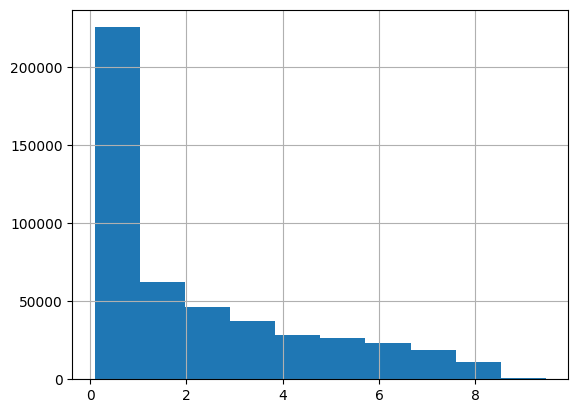

In [4]:
train = train[train["score"] > 0.1]
train["score"].hist()

In [5]:
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from tqdm import tqdm

train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:06<00:00, 45.94it/s]


In [6]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission_after_nms.csv"), index=False)

score: 0.7503


event   tolerance
onset   12           0.162181
        36           0.558555
        60           0.714681
        90           0.793505
        120          0.829453
        150          0.851710
        180          0.863887
        240          0.880498
        300          0.888274
        360          0.893372
wakeup  12           0.149551
        36           0.588709
        60           0.735179
        90           0.800305
        120          0.838733
        150          0.864030
        180          0.878087
        240          0.894712
        300          0.905307
        360          0.914524
dtype: float64